In [ ]:
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from src.aliases import UInt8Array
from src.api.models.pydantic import SimRoomClassDTO
from src.api.models.vector_index import FAISSIndexWithMetadata
from src.api.services import embeddings_service, simrooms_service, labeling_service

from controlled_experiment.settings import (
    DIFF_BACKGROUND_INDEXES_PATH,
    LABELING_REC_DIFF_BACKGROUND_ID,
    LABELING_REC_SAME_BACKGROUND_ID,
    SAME_BACKGROUND_INDEXES_PATH,
)

2025-04-09 22:52:03.475304: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-09 22:52:03.483033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744231923.492100  318771 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744231923.495023  318771 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-09 22:52:03.505980: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Creating Embeddings from Annotations for each Class:

Some important notes here:

We should probably be setting a minimum sample count per class when labeling. 
Additionally, we should set an upper bound on the number of samples per class added to the database, based on the lowest amount of samples available for the classes.

Question: Should we do data augmentation as well?

The following are some interesting parameters to experiment with based on experimentation on real-world data:
1. Sample count per class
2. Data augmentation (and which kinds?)
3. Same number of samples per class or not?
4. ?

In [ ]:
def get_annotated_samples(
    annotated_classes: list[SimRoomClassDTO],
) -> tuple[list[UInt8Array], list[int]]:
    rois = []
    class_ids = []
    mask_areas = []

    # Check if there are enough samples for each class
    for anno_class in annotated_classes:
        annotation_paths = labeling_service.get_class_tracking_results(anno_class.id)
        for annotation_path in annotation_paths:
            file = np.load(annotation_path)
            mask_area = np.sum(file["mask"])
            rois.append(file["roi"])
            class_ids.append(int(file["class_id"]))
            mask_areas.append(mask_area)

    return rois, class_ids, mask_areas


def select_samples(
    class_ids: list[int], min_samples_per_class: int
) -> tuple[list[UInt8Array], list[int]]:
    class_ids_np: UInt8Array = np.array(class_ids)
    selected_indices = []
    for cls in np.unique(class_ids_np):
        cls_indices = np.where(cls == class_ids_np)[0]
        # Randomly choose N indices if more than N available, otherwise take all indices
        if len(cls_indices) > min_samples_per_class:
            chosen = np.random.choice(
                cls_indices, size=min_samples_per_class, replace=False
            )
        else:
            chosen = cls_indices
        selected_indices.extend(chosen)

    return np.array(selected_indices)


def create_vector_index(
    dinov2, calibration_id: int, min_samples_per_class: int, output_path: Path
):
    annotated_classes = get_tracked_classes(calibration_id)
    for anno_class in annotated_classes:
        if len(anno_class.annotation_paths) < min_samples_per_class:
            raise ValueError(
                f"Not enough samples for class {anno_class.class_name} ({len(anno_class.annotation_paths)} < {min_samples_per_class})"
            )

    rois, class_ids, mask_areas = get_annotated_samples(annotated_classes)
    selected_indices = select_samples(class_ids, min_samples_per_class)
    rois = [rois[i] for i in selected_indices]
    class_ids = [class_ids[i] for i in selected_indices]
    mask_areas = [mask_areas[i] for i in selected_indices]

    # Show a sample as a sanity check
    sample_idx = 0
    roi = rois[sample_idx]
    print(f"Mask area: {mask_areas[sample_idx]}")
    plt.title(f"Class ID: {class_ids[sample_idx]}")
    plt.imshow(roi)
    plt.show()

    index = FAISSIndexWithMetadata(dim=embeddings_service.EMBEDDING_DIM)
    for embeddings, batch_start, batch_end in embeddings_service.get_embeddings(
        dinov2, rois, log_performance=True
    ):
        batch_class_ids = class_ids[batch_start:batch_end]
        batch_mask_areas = mask_areas[batch_start:batch_end]
        metadata = [
            {"mask_area": int(mask_area), "class_id": int(class_id)}
            for mask_area, class_id in zip(
                batch_mask_areas, batch_class_ids, strict=False
            )
        ]

        index.add(embeddings, metadata)

    index.write(output_path)

In [ ]:
dinov2 = embeddings_service.load_model()

Minimum samples per class: 648
Mask area: 2056


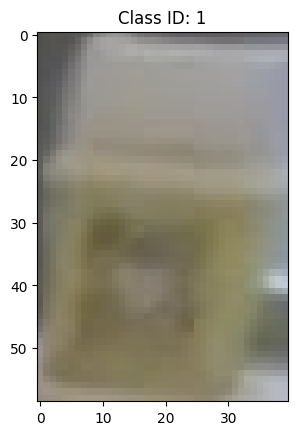

Generated 1500 embeddings at 416.62 samples per second
Mask area: 1566


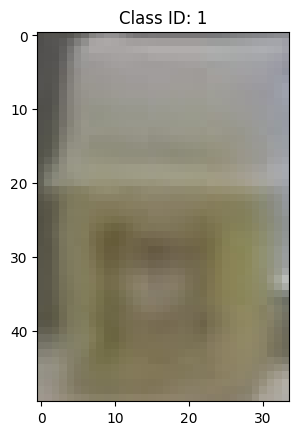

Generated 3000 embeddings at 653.29 samples per second
Mask area: 3736


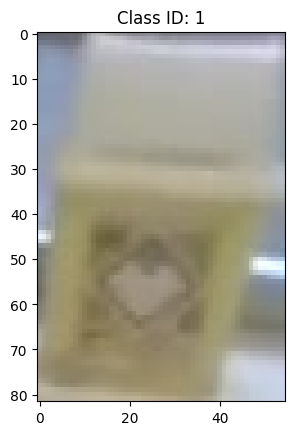

Generated 4500 embeddings at 397.75 samples per second
Mask area: 1285


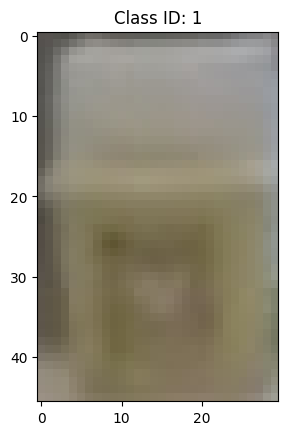

Generated 6000 embeddings at 502.90 samples per second
Mask area: 1713


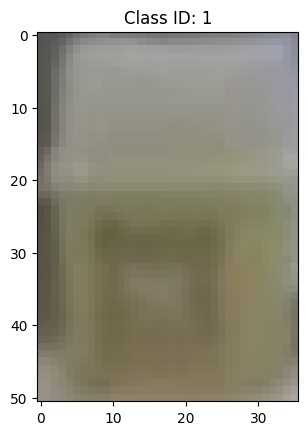

Generated 7500 embeddings at 408.95 samples per second
Mask area: 6991


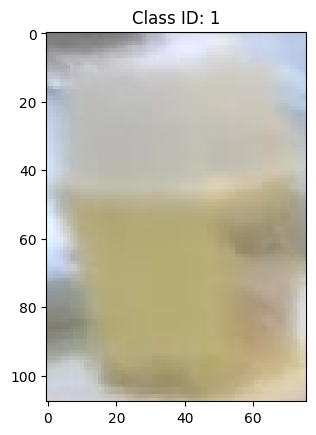

Generated 9000 embeddings at 413.02 samples per second
Mask area: 1216


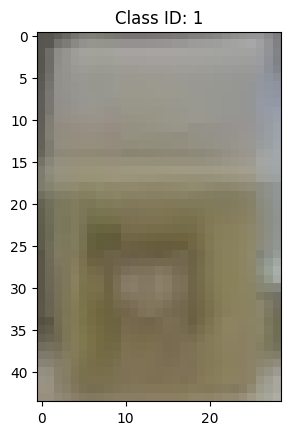

Generated 9720 embeddings at 414.69 samples per second


In [ ]:
if SAME_BACKGROUND_INDEXES_PATH.exists():
    shutil.rmtree(SAME_BACKGROUND_INDEXES_PATH)
if DIFF_BACKGROUND_INDEXES_PATH.exists():
    shutil.rmtree(DIFF_BACKGROUND_INDEXES_PATH)
SAME_BACKGROUND_INDEXES_PATH.mkdir(parents=True, exist_ok=True)
DIFF_BACKGROUND_INDEXES_PATH.mkdir(parents=True, exist_ok=True)

same_background_calibration_id = recording_id_to_calibration_id(
    LABELING_REC_SAME_BACKGROUND_ID
)
diff_background_calibration_id = recording_id_to_calibration_id(
    LABELING_REC_DIFF_BACKGROUND_ID
)

# Check what the minimum number of samples per class is:
annotated_classes = get_tracked_classes(same_background_calibration_id)

min_samples_per_class = 100000000000
for anno_class in annotated_classes:
    if len(anno_class.annotation_paths) < min_samples_per_class:
        min_samples_per_class = len(anno_class.annotation_paths)
print(f"Minimum samples per class: {min_samples_per_class}")

samples_per_class = [100, 200, 300, 400, 500, 600, min_samples_per_class]


def create_vector_indexes(dinov2, calibration_id: int, vector_indexes_path: Path):
    for samples in samples_per_class:
        output_path = vector_indexes_path / f"{samples}_samples_per_class.index"
        create_vector_index(dinov2, calibration_id, samples, output_path)


create_vector_indexes(
    dinov2, same_background_calibration_id, SAME_BACKGROUND_INDEXES_PATH
)
# create_vector_indexes(dinov2, diff_background_calibration_id, DIFF_BACKGROUND_INDEXES_PATH)